# GMM and EM
Gaussian Mixture Models and Expectation Maximization.

Updated after switch to GenCode 43, but we don't use the sequence here.

Use mean CNRIC (14 cell lines) and entire data set (not train set). 

In [1]:
import numpy as np
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture
import scipy.stats as ss

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/


In [3]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080','HUVEC','MCF.7','NCI.H460','NHEK',\
     'SK.MEL.5','SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1] # exclude H1.hESC
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC


In [4]:
class RCI_Loader():
    def __init__(self):
        self.cache=dict() 
        
    def load_gene_rci_values(self,filepath):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                #if len(gene_to_rci.keys())>=6423:
                #    break # balance the sets for comparable BIC?
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    numerics = [float(x) for x in fields]
                    mean_rci = np.nanmean(numerics)
                    if not np.isnan(mean_rci):
                        gene_to_rci[gene_id] = mean_rci
        print('File heading:',header)
        print('Num genes:',len(gene_to_rci.keys()))
        return gene_to_rci

In [5]:
def plot(X,left=None,right=None,middle=None,discrim=None,num_bins=50):
    pyplot.hist(X, bins=num_bins, density=True)
    if left is not None:
        pyplot.axvline(x=left,color='y')
    if right is not None:
        pyplot.axvline(x=right,color='y')
    if middle is not None:
        pyplot.axvline(x=middle,color='g')
    if discrim is not None:
        pyplot.axvline(x=discrim,color='r')
    pyplot.show()
    
def show_gmm(model,X):
    print(model)
    print('AIC',model.aic(X),'BIC',model.bic(X),'score',model.score(X))
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 'cov=',model.covariances_[i])

In [6]:
def place_discriminant(minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
    bests = []
    left = None
    middle = None
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    zmin = max(mean1-3*std1,mean2-3*std2)
    zmax = min(mean1+3*std1,mean2+3*std2)
    zrange = (zmax-zmin)
    for i in range(101):
        if left is None:
            x = zrange * (i-1)/100.0 + zmin
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            left = p1-p2
        if middle is None:
            x = zrange * (i)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            middle = p1-p2
        x = zrange * (i+1)/100.0 + zmin 
        p1 = ss.norm(mean1,var1).pdf(x)*wgt1
        p2 = ss.norm(mean2,var2).pdf(x)*wgt2
        right = p1-p2
        if left * right < 0.0:
            bests.append(x)
        left = middle
        middle = right
    if len(bests)==0:
        return None
    return np.mean(bests)

In [7]:
def make_plots(filename,num_means):
    filepath = DATA_DIR + filename
    loader = RCI_Loader()

    gene_to_rci = loader.load_gene_rci_values(filepath)
    logs = list(gene_to_rci.values())
    values = np.array(logs)
    values = values.reshape(-1, 1)

    model_1 = GaussianMixture(n_components=1, verbose=0, covariance_type='spherical', n_init=10) 
    model_1.fit(values)
    model_2 = GaussianMixture(n_components=2, verbose=0, covariance_type='spherical', n_init=10) 
    model_2.fit(values)
    model_3 = GaussianMixture(n_components=3, verbose=0, covariance_type='spherical', n_init=10) 
    model_3.fit(values)

    discrim = place_discriminant(
        min(logs),max(logs),
        model_2.means_[0],model_2.covariances_[0],model_2.weights_[0],
        model_2.means_[1],model_2.covariances_[1],model_2.weights_[1])

    print('Single mean',model_1.means_[0])
    print('Double mean',model_2.means_[0],model_2.means_[1])
    print('Gaussian discriminant',discrim)
    if discrim is None:   # not expected, but just in case...
        discrim = model_1.means_
    middle = model_1.means_[0]
    left =  model_2.means_[0]
    right = model_2.means_[1]

    plot(logs,left=left,right=right)
    show_gmm(model_2,values)

File heading: gene_id,A549,H1.hESC,HeLa.S3,HepG2,HT1080,HUVEC,MCF.7,NCI.H460,NHEK,SK.MEL.5,SK.N.DZ,SK.N.SH,GM12878,K562,IMR.90

Num genes: 6423
Single mean [-1.03944031]
Double mean [-0.05086062] [-2.3468156]
Gaussian discriminant -1.5350091340600782


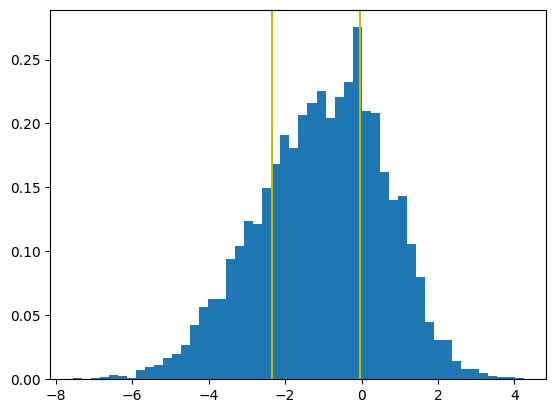

GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 24732.15465159961 BIC 24765.9928544859 score -1.924502152545509
Gaussian 0 mean= [-0.05086062] wgt= 0.5694254921936542 cov= 1.2920817371742637
Gaussian 1 mean= [-2.3468156] wgt= 0.4305745078063459 cov= 1.797131750759865


In [8]:
RCI_FILE =      'all.lncRNA_RCI.csv'  
make_plots(RCI_FILE,2)

File heading: gene_id,A549,H1.hESC,HeLa.S3,HepG2,HT1080,HUVEC,MCF.7,NCI.H460,NHEK,SK.MEL.5,SK.N.DZ,SK.N.SH,GM12878,K562,IMR.90

Num genes: 17668
Single mean [-0.21743913]
Double mean [0.34425984] [-1.17825107]
Gaussian discriminant 0.8950875214935543


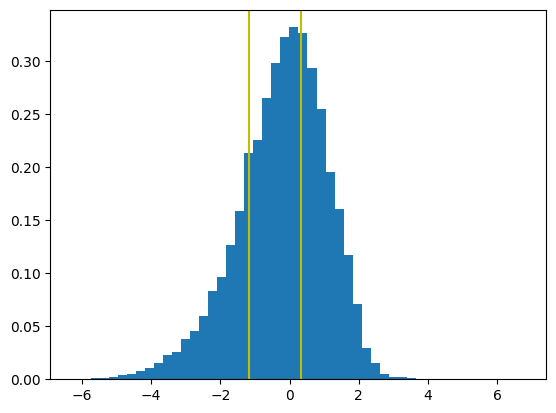

GaussianMixture(covariance_type='spherical', n_components=2, n_init=10)
AIC 58292.629411072456 BIC 58331.52696293604 score -1.6493838977550503
Gaussian 0 mean= [0.34425984] wgt= 0.6310706482767017 cov= 0.8100658100741257
Gaussian 1 mean= [-1.17825107] wgt= 0.36892935172329827 cov= 1.6577542693111587


In [9]:
RCI_FILE =      'all.pc_RCI.csv'  
make_plots(RCI_FILE,1)